<a href="https://colab.research.google.com/github/chanukaDissanayaka/RideFareClassification/blob/master/Ridefare_submission_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math
from sklearn.cluster import KMeans

from datetime import datetime, timedelta
from pandas import DataFrame

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import numpy as np

RANDOM_SEED = 4

In [0]:
dataframe = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

dataframe.isna().sum(axis = 0)
#dataframe = dataframe.fillna(method='ffill')
dataframe = dataframe.dropna()

In [0]:
def preprocess_train_data(dataframe):
  feature_set = dataframe.iloc[:,1:13]

  features = feature_set

  features['pickup_time'] = pd.to_datetime(features['pickup_time'], format="%m/%d/%Y %H:%M")
  features['drop_time'] = pd.to_datetime(features['drop_time'], format="%m/%d/%Y %H:%M")

  td = features

  td['pickup_time_year'] = td['pickup_time'].dt.year
  td['pickup_time_month'] = td['pickup_time'].dt.month
  td['pickup_time_day'] = td['pickup_time'].dt.day
  td['pickup_time_hour'] = td['pickup_time'].dt.hour
  td['pickup_time_minute'] = td['pickup_time'].dt.minute

  td['drop_time_year'] = td['drop_time'].dt.year
  td['drop_time_month'] = td['drop_time'].dt.month
  td['drop_time_day'] = td['drop_time'].dt.day
  td['drop_time_hour'] = td['drop_time'].dt.hour
  td['drop_time_minute'] = td['drop_time'].dt.minute

  td = td.drop('pickup_time',1)
  td = td.drop('drop_time',1)

  td = get_trip_distance(td)
  td = get_X_distance(td)
  td = get_Y_distance(td)
  #td = get_pick_XY(td)
  #td = get_drop_XY(td)

  td = getZone(td)

  return td

def get_labels(dataframe):
  label_set = dataframe.iloc[:, 13:14]

  rev_label_set = label_set.replace({'correct':'incorrect', 'incorrect':'correct'})

  encoder = LabelEncoder()
  encoder.fit(rev_label_set)
  labels = encoder.transform(rev_label_set)
  return labels

def set_time_of_the_day(cleaned_train_set):
  cleaned_train_set.head()
  newFrame = cleaned_train_set
  tt = newFrame

  d0_index = newFrame[(newFrame['pickup_time_hour']>=0) & (newFrame['pickup_time_hour'] < 6 )].index
  tt.loc[d0_index,'time_of_day']=0

  d1_index = newFrame[(newFrame['pickup_time_hour']>=6) & (newFrame['pickup_time_hour'] < 12 )].index
  tt.loc[d1_index,'time_of_day']=1

  d2_index = newFrame[(newFrame['pickup_time_hour']>=12) & (newFrame['pickup_time_hour'] < 18 )].index
  tt.loc[d2_index,'time_of_day']=2

  d3_index = newFrame[(newFrame['pickup_time_hour']>=18) & (newFrame['pickup_time_hour'] < 24 )].index
  tt.loc[d3_index,'time_of_day']=3

  return tt

def get_trip_distance(frame):
  newFrame = frame
  newFrame["distance"] = (((frame['pick_lat']-frame['drop_lat'])**2)+((frame['pick_lon']-frame['drop_lon'])**2)**0.5)
  return newFrame

def get_X_distance(frame):
  newFrame = frame
  newFrame["distance_X"] = ((frame['pick_lat']-frame['drop_lat']))
  return newFrame

def get_Y_distance(frame):
  newFrame = frame
  newFrame["distance_Y"] = ((frame['pick_lon']-frame['drop_lon']))
  return newFrame

def get_pick_XY(frame):
  newFrame = frame
  newFrame["pick_X"] = np.cos(frame['pick_lat'])* np.cos(frame['pick_lon'])
  newFrame["pick_Y"] = np.cos(frame['pick_lat'])* np.sin(frame['pick_lon'])
  return newFrame

def get_drop_XY(frame):
  newFrame = frame
  newFrame["drop_X"] = np.cos(frame['drop_lat'])* np.cos(frame['drop_lon'])
  newFrame["drop_Y"] = np.cos(frame['drop_lat'])* np.sin(frame['drop_lon'])
  return newFrame

def getZone(dataframe):
  newFrame = dataframe

  pickzone = dataframe[['pick_lat','pick_lon']]
  kmeans = KMeans(n_clusters=4, random_state=0).fit(pickzone)
  newFrame['pickzone'] = kmeans.labels_

  dropzone = dataframe[['drop_lat','drop_lon']]
  kmeans = KMeans(n_clusters=4, random_state=0).fit(dropzone)
  newFrame['dropzone'] = kmeans.labels_
  return newFrame

In [0]:
cleaned_train_set = preprocess_train_data(dataframe)
labels = get_labels(dataframe)
cleaned_train_set.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_year,pickup_time_month,pickup_time_day,pickup_time_hour,pickup_time_minute,drop_time_year,drop_time_month,drop_time_day,drop_time_hour,drop_time_minute,distance,distance_X,distance_Y,pickzone,dropzone
0,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,2019,11,1,0,20,2019,11,1,0,34,0.022663,-0.04078,0.0210,1,0
1,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,2019,11,1,0,56,2019,11,1,1,9,0.006875,-0.02784,0.0061,1,0
2,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,2019,11,1,1,8,2019,11,1,1,26,0.050301,-0.02830,-0.0495,1,0
3,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,2019,11,1,2,27,2019,11,1,2,37,0.007603,-0.00178,-0.0076,1,0
5,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,2019,11,1,5,38,2019,11,1,6,35,0.078384,0.21537,0.0320,3,0


In [0]:
cols_all = ['additional_fare','duration','meter_waiting',
               'meter_waiting_fare','meter_waiting_till_pickup','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','pickup_time_year','pickup_time_month','pickup_time_day','pickup_time_hour','pickup_time_minute',
                'drop_time_year','drop_time_month','drop_time_day','drop_time_hour','drop_time_minute','distance',
                'distance_X','distance_Y','pick_X','pick_Y','drop_X','drop_Y','pickzone','dropzone']

numeric_cols = ['meter_waiting','meter_waiting_fare','meter_waiting_till_pickup',
               'additional_fare','duration','fare', 'distance'
                'distance_X', 'distance_Y']
categorical_cols = ['pickup_time_day','pickup_time_hour']

n_test = ['additional_fare','duration','meter_waiting',
               'meter_waiting_fare','meter_waiting_till_pickup','pick_lat','pick_lon','drop_lat','drop_lon',
               'fare','pickup_time_year','pickup_time_day','pickup_time_hour','pickup_time_minute',
                'drop_time_day','drop_time_hour','drop_time_minute','distance',
                'distance_X','distance_Y']
                
c_test = ['pickup_time_year','pickup_time_month','pickup_time_hour','drop_time_year','drop_time_month',
          'pickzone','dropzone']

In [0]:
X_train, X_eval, Y_train, Y_eval = train_test_split(
    cleaned_train_set,
    labels,
    test_size=0.20,
    shuffle=True,
    stratify=labels,
    random_state=RANDOM_SEED
)

In [0]:
numeric_preprocessing_steps = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

categorical_transformer_ordinal = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
    ])



preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_transformer_ordinal, categorical_cols)
    ],
    remainder = "drop"
)

In [0]:
data_pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

In [0]:
data_pipeline.fit(X_train)
d_train = data_pipeline.transform(X_train)
d_eval = data_pipeline.transform(X_eval)

ValueError: ignored

In [0]:
d_train.shape

(13574, 14)

In [0]:
d_train[0]

array([2.13821228e-04, 0.00000000e+00, 2.06676026e-03, 8.20631136e-04,
       1.33297494e-03, 5.27573862e-03, 4.78260870e-01, 5.29539131e-07,
       9.89144463e-01, 1.12277126e-02, 1.00000000e+00, 0.00000000e+00])

In [0]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:5, 1:1}, y=Y_train)

In [0]:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0:0.1, 1:0.90}, y=Y_train)


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(random_state=0, n_estimators = 1000, max_depth =8, subsample = 1.0, verbose = 2)
gbclf.fit(d_train, Y_train, sample_w)
gbclf.score(d_eval, Y_eval)

In [0]:
#drop lat lon all
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(random_state=0, n_estimators = 1000, max_depth =8, subsample = 1.0)
gbclf.fit(d_train, Y_train, sample_w)
gbclf.score(d_eval, Y_eval)

0.9563936358279317

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(random_state=0, n_estimators = 800, max_depth =10, subsample = 1.0)
gbclf.fit(d_train, Y_train, sample_w)
gbclf.score(d_eval, Y_eval)

0.9490276959340012

feature Importance

In [0]:
data_pipeline.fit(cleaned_train_set)
d_all = data_pipeline.transform(cleaned_train_set)
y_all = labels

In [0]:
cleaned_train_set.shape

(16968, 25)

In [0]:
d_all.shape

(16968, 27)

Feature: 0, Score: 5.53088
Feature: 1, Score: 52.78691
Feature: 2, Score: -30.83087
Feature: 3, Score: 27.37865
Feature: 4, Score: -0.85472
Feature: 5, Score: -1778891746.24844
Feature: 6, Score: -234822991.08330
Feature: 7, Score: 35512130548.68259
Feature: 8, Score: 7042125515.94219
Feature: 9, Score: -6.13206
Feature: 10, Score: -13048760.62984
Feature: 11, Score: 254.05766
Feature: 12, Score: 20154973911.60528
Feature: 13, Score: 0.34252
Feature: 14, Score: -254.06542
Feature: 15, Score: -8.07181
Feature: 16, Score: -0.34702
Feature: 17, Score: 23.27892
Feature: 18, Score: 34671441102.60156
Feature: 19, Score: 7093646512.37220
Feature: 20, Score: 0.51383
Feature: 21, Score: -0.75079
Feature: 22, Score: -0.52592
Feature: 23, Score: 0.64010
Feature: 24, Score: 13049531.65444
Feature: 25, Score: 254.37615
Feature: 26, Score: -876303213.19744
Feature: 27, Score: -770.92571
Feature: 28, Score: -254.32973
Feature: 29, Score: 0.00749
Feature: 30, Score: 0.00823


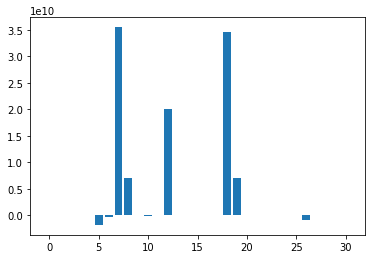

In [0]:

# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

model = LinearRegression()
model.fit(d_all, y_all)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature: 0, Score: -0.51295
Feature: 1, Score: -2.89722
Feature: 2, Score: -2.68403
Feature: 3, Score: -2.55461
Feature: 4, Score: -0.50341
Feature: 5, Score: -0.21453
Feature: 6, Score: 0.16054
Feature: 7, Score: 0.11713
Feature: 8, Score: 0.45867
Feature: 9, Score: -6.54439
Feature: 10, Score: 0.36336
Feature: 11, Score: -0.05167
Feature: 12, Score: -0.00024
Feature: 13, Score: -0.08409
Feature: 14, Score: -0.08553
Feature: 15, Score: 0.07219
Feature: 16, Score: 0.01891
Feature: 17, Score: 0.10039
Feature: 18, Score: 0.48301
Feature: 19, Score: 0.15811
Feature: 20, Score: 0.10035
Feature: 21, Score: -0.22621
Feature: 22, Score: -1.51098
Feature: 23, Score: 0.50830
Feature: 24, Score: 0.36336
Feature: 25, Score: 0.59834
Feature: 26, Score: -0.00543
Feature: 27, Score: 0.42805
Feature: 28, Score: -0.07396
Feature: 29, Score: 0.04440
Feature: 30, Score: 0.14810


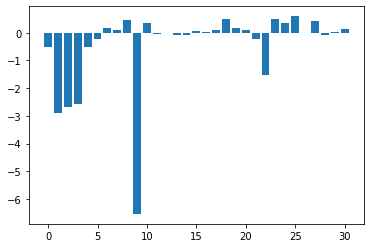

In [0]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset

model = LogisticRegression()
# fit the model
model.fit(d_all, y_all)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [0]:
d_all.shape

(16968, 31)

In [0]:
for i,v in enumerate(importance):
  if((v < 0.06) and (v > -0.06)):
	  print('Feature: %0d, Score: %.5f' % (i,v), keyss[i])

In [0]:
keyss = cleaned_train_set.keys()

In [0]:
keyss.size

29

In [0]:
d_all.shape

(16968, 14)

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbclf, d_all, y_all, cv=5, scoring='f1_micro')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Streaming output truncated to the last 5000 lines.
         7           0.3683            2.35m
         8           0.3560            2.34m
         9           0.3424            2.33m
        10           0.3316            2.33m
        11           0.3210            2.33m
        12           0.3114            2.32m
        13           0.3031            2.32m
        14           0.2966            2.31m
        15           0.2912            2.31m
        16           0.2857            2.32m
        17           0.2825            2.31m
        18           0.2761            2.31m
        19           0.2698            2.31m
        20           0.2650            2.30m
        21           0.2594            2.30m
        22           0.2530            2.30m
        23           0.2499            2.30m
        24           0.2445            2.29m
        25           0.2423            2.29m
        26           0.2367            2.29m
        27           0.2251            2.28m
    

In [0]:
cleaned_test_data = preprocess_train_data(test)

cleaned_test_data = cleaned_test_data.drop('pickup_time_year',1)
cleaned_test_data = cleaned_test_data.drop('pickup_time_month',1)
cleaned_test_data = cleaned_test_data.drop('pickup_time_day',1)
cleaned_test_data = cleaned_test_data.drop('pickup_time_minute',1)
cleaned_test_data = cleaned_test_data.drop('drop_time_year',1)
cleaned_test_data = cleaned_test_data.drop('drop_time_month',1)
cleaned_test_data = cleaned_test_data.drop('drop_time_day',1)
cleaned_test_data = cleaned_test_data.drop('drop_time_minute',1)

test_set = data_pipeline.transform(cleaned_test_data)

In [0]:
test_set.shape

(8576, 11)

In [0]:
preds = gbclf.predict(test_set)
print(preds)

[1 1 1 ... 1 1 1]


In [0]:
preds.shape

(8576,)

In [0]:
output = pd.DataFrame(test,columns=['tripid'])
output['prediction'] = preds
output.head()

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1


In [0]:
output.to_csv('/content/Ridefare_submission_9.csv',index=False)

In [0]:
base = gbclf.predict(d_eval)
#print("keras", f1_score(Y_eval, eval_predict, average='micro'))
print("base", f1_score(Y_eval, base, average='micro'))

from sklearn.metrics import confusion_matrix

results = gbclf.predict(d_eval)
confusion_matrix(Y_eval, results)

base 0.9490276959340012


array([[ 170,  135],
       [  38, 3051]])

In [0]:
k =0
for i in pred_proba:
  print("%0.5f"%i[0],"%0.4f"%i[1], Y_eval[k])
  k = k+1

In [0]:
pred_proba = gbclf.predict_proba(d_eval)

threshold = 0.3

preds = (pred_proba [:,1] >= threshold).astype('int')

In [0]:
base = gbclf.predict(d_eval)
#print("keras", f1_score(Y_eval, eval_predict, average='micro'))
print("base", f1_score(Y_eval, base, average='micro'))

from sklearn.metrics import confusion_matrix

results = gbclf.predict(d_eval)
confusion_matrix(Y_eval, results)

In [0]:
pred_proba = gbclf.predict_proba(d_eval)

threshold = 0.05

preds = (pred_proba [:,0] <= threshold).astype('int')

In [0]:
print(preds)
print("base", f1_score(Y_eval, preds, average='micro'))
confusion_matrix(Y_eval, preds)

[1 0 1 ... 1 1 1]
base 0.940777843252799


array([[ 200,  105],
       [  96, 2993]])

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, class_weight={0:1, 1:8}, max_depth = 20)
clf.fit(d_train, Y_train)
clf.score(d_eval, Y_eval)

0.9281084266352386

In [0]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

test = SelectKBest(score_func=f_classif, k=17)
fit = test.fit(cleaned_train_set, labels)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features_selected = fit.transform(cleaned_train_set)

k = cleaned_train_set.keys()
j =0
for i in fit.scores_:
  print (i, k[j])
  j = j+1

[2.862e+01 2.200e+02 1.979e+02 1.834e+02 2.146e+01 1.303e+01 2.470e+01
 2.296e+00 1.560e+01 5.936e+02 3.932e+01 3.047e+01 1.918e+00 2.401e-01
 3.819e-01 3.944e+01 3.069e+01 1.948e+00 1.562e-01 1.302e-06 9.528e-02
 3.425e-01 6.312e-01 2.278e+01 1.716e+01 3.041e+01 1.389e+01 1.161e+01
 8.059e+00]
28.623953436167696 additional_fare
220.02687922383885 duration
197.9049742837943 meter_waiting
183.41722760784106 meter_waiting_fare
21.46446934945016 meter_waiting_till_pickup
13.030155560634784 pick_lat
24.700950555351888 pick_lon
2.296175046888747 drop_lat
15.60186867469649 drop_lon
593.5972743079656 fare
39.319627310339435 pickup_time_year
30.471478388840243 pickup_time_month
1.9176663374588543 pickup_time_day
0.2401075392209639 pickup_time_hour
0.3819274210402434 pickup_time_minute
39.44128814160557 drop_time_year
30.691795952060406 drop_time_month
1.9476674383550614 drop_time_day
0.15620096048043602 drop_time_hour
1.3024827082722546e-06 drop_time_minute
0.095278364697288 distance
0.3424839